<a href="https://colab.research.google.com/github/j1zha/DSC_180B/blob/main/Transformer_Nvidia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install torch torchvision torchaudio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 96.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 65.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [3]:
pip install scikit-learn matplotlib pandas numpy yfinance

In [156]:
import yfinance as yf
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

In [157]:
# Download the stock data of Nvidia
start_date = "2024-01-01"
end_date = datetime.now()
nvda_data = yf.download("NVDA", start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [158]:
# Choose 'Close' price column
nvda_prices= nvda_data[['Close']].reset_index()
nvda_prices.rename(columns={'Date':'timestamp','Close':'value'}, inplace = True)

In [159]:
nvda_prices

Price,timestamp,value
Ticker,,NVDA
0,2024-01-02,48.154346
1,2024-01-03,47.555515
2,2024-01-04,47.984398
3,2024-01-05,49.083080
4,2024-01-08,52.238182
...,...,...
267,2025-01-27,118.419998
268,2025-01-28,128.990005
269,2025-01-29,123.699997


In [160]:
# 找到最小值的日期和对应股价
min_value_row = nvda_prices.loc[nvda_prices['value'].idxmin()]
print("Row with Minimum Value:")
print(min_value_row)


Row with Minimum Value:
Price   timestamp      value
Ticker                  NVDA
1      2024-01-03  47.555515


In [161]:
# normalization
scaler  = RobustScaler()
scaler.fit(nvda_prices[['value']].iloc[:-30])
nvda_prices['scaled_value'] = scaler.fit_transform(nvda_prices['value'].values.reshape(-1,1))

print("Real Min of Training Data:", nvda_prices['value'].iloc[:-30].min())
print("Real Max of Training Data:", nvda_prices['value'].iloc[:-30].max())

Real Min of Training Data: Ticker
NVDA    47.555515
dtype: float64
Real Max of Training Data: Ticker
NVDA    148.869751
dtype: float64


In [163]:
# transform
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        sequences.append(seq)
        targets.append(data[i+seq_length])
    return np.array(sequences), np.array(targets)

seq_length = 45
input = nvda_prices['scaled_value'].values.tolist()
X, y = create_sequences(input, seq_length)

In [164]:
# pytorch tensor
X_train, y_train = torch.tensor(X[:-30], dtype=torch.float32), torch.tensor(y[:-30], dtype=torch.float32)
noise_factor = 0.01
y_train = y_train + noise_factor * torch.randn_like(y_train)  # 添加小量噪声

X_test, y_test = torch.tensor(X[-30:], dtype=torch.float32), torch.tensor(y[-30:], dtype=torch.float32)

In [165]:
import torch
import torch.nn as nn

class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim=1,d_model=256, num_heads=8, num_layers=6, dim_feedforward = 256, dropout=0.3):
        super(TimeSeriesTransformer, self).__init__()
        self.encoder = nn.Linear(input_dim, d_model)
        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=num_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.decoder = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.encoder(x)
        x = self.transformer(x, x)
        x = self.decoder(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TimeSeriesTransformer().to(device)

In [166]:
epochs=400
lr=0.001
bath_size=32
criterion = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
X_test = X_test.unsqueeze(-1)
X_train = X_train.unsqueeze(-1)

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    X_train_gpu, y_train_gpu = X_train.to(device), y_train.to(device)
    outputs = model(X_train_gpu)

    loss = criterion(outputs[:, -1, :].squeeze(), y_train_gpu)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 5== 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

Epoch [5/400], Loss: 0.4539
Epoch [10/400], Loss: 0.1556
Epoch [15/400], Loss: 0.1466
Epoch [20/400], Loss: 0.1627
Epoch [25/400], Loss: 0.1282
Epoch [30/400], Loss: 0.1243
Epoch [35/400], Loss: 0.1271
Epoch [40/400], Loss: 0.1173
Epoch [45/400], Loss: 0.1157
Epoch [50/400], Loss: 0.1100
Epoch [55/400], Loss: 0.1103
Epoch [60/400], Loss: 0.1167
Epoch [65/400], Loss: 0.1143
Epoch [70/400], Loss: 0.1077
Epoch [75/400], Loss: 0.1188
Epoch [80/400], Loss: 0.1052
Epoch [85/400], Loss: 0.1190
Epoch [90/400], Loss: 0.1070
Epoch [95/400], Loss: 0.1067
Epoch [100/400], Loss: 0.1078
Epoch [105/400], Loss: 0.1076
Epoch [110/400], Loss: 0.1096
Epoch [115/400], Loss: 0.1077
Epoch [120/400], Loss: 0.1061
Epoch [125/400], Loss: 0.1092
Epoch [130/400], Loss: 0.1041
Epoch [135/400], Loss: 0.1010
Epoch [140/400], Loss: 0.1073
Epoch [145/400], Loss: 0.1018
Epoch [150/400], Loss: 0.0995
Epoch [155/400], Loss: 0.1027
Epoch [160/400], Loss: 0.1032
Epoch [165/400], Loss: 0.1033
Epoch [170/400], Loss: 0.1051


In [167]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)


X_train shape: torch.Size([197, 45, 1])
y_train shape: torch.Size([197])


In [168]:
# predictions
model.eval()
X_test_gpu = X_test.to(device)
predictions = model(X_test_gpu).detach().cpu().numpy()
predictions = predictions[:, -1, :]

predictions = scaler.inverse_transform(predictions.reshape(-1, 1))
y_test_real = scaler.inverse_transform(y_test.unsqueeze(-1).numpy())

In [169]:
print("Mean of y_test_real:", np.mean(y_test_real))
print("Mean of predictions:", np.mean(predictions))

Mean of y_test_real: 135.59134
Mean of predictions: 129.94377


In [170]:
predictions

array([[129.94374],
       [129.94374],
       [129.94374],
       [129.94374],
       [129.94374],
       [129.94374],
       [129.94374],
       [129.94374],
       [129.94374],
       [129.94374],
       [129.94374],
       [129.94374],
       [129.94374],
       [129.94374],
       [129.94374],
       [129.94374],
       [129.94374],
       [129.94374],
       [129.94374],
       [129.94374],
       [129.94374],
       [129.94374],
       [129.94374],
       [129.94374],
       [129.94374],
       [129.94374],
       [129.94374],
       [129.94374],
       [129.94374],
       [129.94374]], dtype=float32)

In [171]:
print("Std of y_test_real:", np.std(y_test_real))  # 真实股价的标准差
print("Std of predictions:", np.std(predictions))  # 预测值的标准差


Std of y_test_real: 7.5128517
Std of predictions: 3.0517578e-05


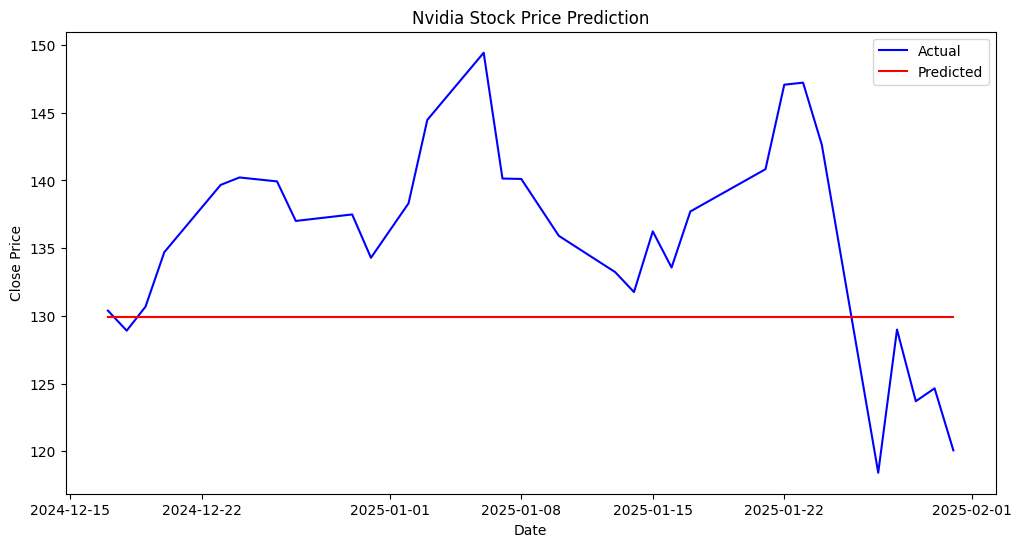

In [172]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(nvda_prices['timestamp'][-30:], y_test_real, label='Actual', color='blue')
plt.plot(nvda_prices['timestamp'][-30:], predictions, label='Predicted', color='red')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Nvidia Stock Price Prediction')
plt.legend()
plt.show()